### Hoda Akl 
-- Adding the cost function of minimum error entropy to the same example solved in the notebook "TimeDelayNN_RecurrentNN.ipynb"
<!-- TDNN code -->

In [1]:
## Most general notebook 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gzip

# Form our test and train data
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Form our test and train data
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import random 

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models 
from keras import layers 
from keras import initializers
from keras.models import load_model
from collections import defaultdict


Using TensorFlow backend.
C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
## 
def create_string(grammar = True):
    """ Returns one array of length 60 that either belongs to the grammar or doesn't """
    n = 60 
    string_arr = np.ones(n)*n
    if grammar ==True: 

        s = 0
        while s<n:
            n_zero = random.randint(1,11)
            if s+n_zero < (n-1):
                string_arr[s:s+n_zero] = np.zeros(n_zero)
                string_arr[s+n_zero] = 1
                s = s+n_zero+1
            else:
                string_arr[s:] = np.zeros(n-s)
                s = n
        
    
    if grammar == False: 
        curr_idx = 0
        while curr_idx<n:
        #     curr_idx  = s
            last_zero_idx = random.randint(curr_idx+1,curr_idx+11)
            if (last_zero_idx <= n):
                string_arr[curr_idx:last_zero_idx] = np.zeros(last_zero_idx -curr_idx)
                curr_idx = last_zero_idx
            else:
                string_arr[curr_idx:] = np.zeros(n -curr_idx)
                curr_idx = n
            ####
        #     for the ones string
            last_ones_idx = random.randint(curr_idx+1,curr_idx+11)
            if (last_ones_idx <= n):
                string_arr[curr_idx:last_ones_idx] = np.ones(last_ones_idx -curr_idx)
                curr_idx = last_ones_idx
            else:
                string_arr[curr_idx:] = np.ones(n -curr_idx)
                curr_idx = n
                
    return string_arr
                

In [3]:
### Creating data : 
# Last column is the labels 
# first 500 samples are grammar 
# last / second 500 samples are grammar 
DataBase = np.ones((1000,61))*200
for i in range(500):
    DataBase[i,:-1] = create_string(grammar = True)
    DataBase[i,-1] = 1
    DataBase[i+500,:-1] = create_string(grammar = False)
    DataBase[i+500,-1] = 0

    

In [4]:
## Preprocessing the data 
## data preprocessing 
# seperate label from sequence
Data = DataBase[:,:-1]
Label = DataBase[:,-1]

PaddedData = np.zeros((Data.shape[0], 81))

PaddedData[:,:60] = Data
PaddedData[:,-1] = Label
np.random.shuffle(PaddedData)
Data_Shuffled_WLabel = PaddedData
Labels = Data_Shuffled_WLabel[:,-1]
Data_processed = Data_Shuffled_WLabel[:,:-1]
scl = MinMaxScaler()
scl.fit(Data_processed)
Data_processed = scl.transform(Data_processed)
from keras.utils import to_categorical
YTrain_oneHot = to_categorical(Labels)
XTrain = Data_processed
# 
X_Train,X_Val,Y_Train_oneHot,Y_Val_oneHot = train_test_split(XTrain,YTrain_oneHot, test_size=0.2, random_state=42)
print('X_Train shape ', X_Train.shape)
print('X_Val shape ', X_Val.shape)
print('Y_Train_oneHot shape ', Y_Train_oneHot.shape)
print('Y_Val_oneHot shape ', Y_Val_oneHot.shape)


X_Train shape  (800, 80)
X_Val shape  (200, 80)
Y_Train_oneHot shape  (800, 2)
Y_Val_oneHot shape  (200, 2)


In [5]:
### preprocessing the testing data 
path = 'C:\everything\Courses\EEL6814 - Neural Networks and Deep Learning\HW\HW4\hmw4test.csv'
TestData=pd.read_csv(path,header=None)
TestData = shuffle(TestData,random_state=42)    # by setting the random state we will get reproducible results
# Split the data into training and testing 
# Scale the input 
#
XTest = TestData.iloc[:,:-1].values
# scl = MinMaxScaler() # for scaling the data
# XDataSc = scl.fit_transfo.rm(XData)
X_Test = scl.transform(XTest)
# XTest = XTest.reshape((XTest.shape[0], XTest.shape[1],1))
YLabels = TestData.iloc[:,-1].values
Y_Test_OneHot = to_categorical(YLabels)
# X_Test = XTest.reshape(XTest.shape[0], XTest.shape[1],1)
print('X_Test shape ', X_Test.shape)
print('Y_Test_OneHot shape ', Y_Test_OneHot.shape)



X_Test shape  (500, 80)
Y_Test_OneHot shape  (500, 2)


In [6]:
## Reshape inputs 
X_Test  = X_Test.reshape(X_Test.shape[0], X_Test.shape[1],1)
X_Val   = X_Val.reshape(X_Val.shape[0], X_Val.shape[1],1)
X_Train = X_Train.reshape(X_Train.shape[0], X_Train.shape[1],1)

In [28]:
from keras import models 
from keras import layers 
## I want to define a model that has input of delay size 
def create_network(delay_size = 7, filters = 30, train_size = 800, batchsize = 10, nh_layers = 1, internal_memory = False):
    net =models.Sequential()
    filters = filters 
    delay_size = delay_size
    input_shape = (train_size,80)
    net.add(layers.Conv1D(filters ,  delay_size,activation='relu', input_shape = (80,1) ,padding="same"))
    
    if nh_layers ==1 : 
        net.add(layers.Flatten())
        net.add(layers.Dense(2,activation='softmax'))
        
        
    if nh_layers > 1:
        for i in range(nh_layers - 1):
            if internal_memory == True:
#                 net.add(layers.Flatten())
                net.add(layers.Conv1D(filters ,  delay_size ,activation='relu',padding="same"))
                net.add(layers.Flatten())
                net.add(layers.Dense(2,activation='softmax'))
            else:
                net.add(layers.Flatten())
                net.add(layers.Dense(50, activation = 'relu'))
                net.add(layers.Dense(2,activation='softmax'))
    
#     net.add(layers.Dense(2,activation='softmax'))
    
    return net


In [29]:
def create_path( nhidden = 1, delay = 20, internal_memory = False):
    if internal_memory == False: 
        internal_memory = 'wo'
    else: 
        internal_memory = 'w'
    path1 = 'C:\everything\Courses\EEL6814 - Neural Networks and Deep Learning\HW\HW4\SavedModel\TDNN' + '_layers_' + str(nhidden) + '_delay_' + str(delay)+ '_'+ internal_memory  +'_memory.h5'
    return path1
    
    
def train_TDNN(network , SavePath, delaysize,  verbose = 1, batchsize = 10, epochs = 1000):
    StopCriteria = 'val_loss'
    callbacks = [EarlyStopping(monitor=StopCriteria, patience=20),
             ModelCheckpoint(filepath=SavePath, monitor=StopCriteria, save_best_only=True)]
    network = network
    network.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    history = network.fit(X_Train,Y_Train_oneHot,
                      epochs=epochs,
                      batch_size=batchsize, # Early stopping,
                         verbose = verbose,
                     validation_data=(X_Val,Y_Val_oneHot),
                     callbacks = callbacks)
    return history

    

In [91]:
nettt = create_network(nh_layers = 2, internal_memory = False)
nettt.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 80, 30)            240       
_________________________________________________________________
flatten_20 (Flatten)         (None, 2400)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                120050    
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 102       
Total params: 120,392
Trainable params: 120,392
Non-trainable params: 0
_________________________________________________________________


In [92]:
path = 'test.h5'
train_TDNN(nettt ,path, delaysize = 7)

Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 1s 647us/step - loss: 0.1045 - accuracy: 0.9513 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/1000
800/800 [==============================] - 0s 328us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/1000
800/800 [==============================] - 0s 337us/step - loss: 8.5415e-04 - accuracy: 1.0000 - val_loss: 6.0434e-04 - val_accuracy: 1.0000
Epoch 4/1000
800/800 [==============================] - 0s 331us/step - loss: 4.9601e-04 - accuracy: 1.0000 - val_loss: 2.4111e-04 - val_accuracy: 1.0000
Epoch 5/1000
800/800 [==============================] - 0s 337us/step - loss: 2.8671e-04 - accuracy: 1.0000 - val_loss: 1.6149e-04 - val_accuracy: 1.0000
Epoch 6/1000
800/800 [==============================] - 0s 352us/step - loss: 1.8615e-04 - accuracy: 1.0000 - val_loss: 8.7410e-05 - val_accuracy: 1.0000
Epoch 7/1000
800/800 [========================

KeyboardInterrupt: 

In [93]:
## This is the condition table each row corresponds to set of conditions 
# first column is delay line , 2nd column is number of hidden layers, third column represents internal memory
Cond_Table = [[7,1,False],[20,1,False], [7,2,False], [20,2,False], [7,2,True], [20,2,True]]

In [94]:
key_list = []
for i in range(len(Cond_Table)):
    new_key = "d_" + str(Cond_Table[i][0]) + "_nh_" +  str(Cond_Table[i][1]) + '_mem_' + str(Cond_Table[i][2])
    key_list.append(new_key)
print(key_list)

['d_7_nh_1_mem_False', 'd_20_nh_1_mem_False', 'd_7_nh_2_mem_False', 'd_20_nh_2_mem_False', 'd_7_nh_2_mem_True', 'd_20_nh_2_mem_True']


In [95]:
# units_to_test = [30,50,70,100]
StopCriteria = 'val_loss'; epochs = 1000; 

npoints = len(key_list)
d_tdnn = defaultdict(lambda: "Not Present") 
d_tdnn["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_tdnn["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_tdnn["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_tdnn["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_arr = np.zeros(npoints)
test_loss_arr = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
#     units = units_to_test[i]
    key = key_list[i]
    print('tdnn on '+ key)
    #create network
#     create_network(delay_size = 7, filters = 30, train_size = 800, batchsize = 10, nh_layers = 1, internal_memory = False):
    delay_size = Cond_Table[i][0]
    nh_layers = Cond_Table[i][1]
    internal_memory = Cond_Table[i][2]
    
    network =create_network(delay_size = delay_size , nh_layers = nh_layers, internal_memory = internal_memory)

    #fit
    SavePath = create_path( nhidden = nh_layers, delay = delay_size, internal_memory = internal_memory)
    History = train_TDNN(network , SavePath, delay_size)
    
#     key = str(LearningRate)
    d_tdnn["train_acc_arr"][key] = History.history['accuracy']
    d_tdnn["train_loss_arr"][key]  = History.history['loss']
    d_tdnn["val_acc_arr"][key] = History.history['val_accuracy']
    d_tdnn["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(SavePath)
    test_loss, test_acc = trained_network.evaluate(X_Test,Y_Test_OneHot)
    test_acc_arr[i] = test_acc
    test_loss_arr[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_tdnn["train_acc_arr"]:
    arr = d_tdnn["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######



tdnn on d_7_nh_1_mem_False
Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 0s 487us/step - loss: 0.3181 - accuracy: 0.8425 - val_loss: 0.0410 - val_accuracy: 1.0000
Epoch 2/1000
800/800 [==============================] - 0s 190us/step - loss: 0.0261 - accuracy: 0.9962 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 3/1000
800/800 [==============================] - 0s 186us/step - loss: 0.0102 - accuracy: 0.9987 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 4/1000
800/800 [==============================] - 0s 191us/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/1000
800/800 [==============================] - 0s 183us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/1000
800/800 [==============================] - 0s 183us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/1000
800/800 [=============================

In [97]:
d_tdnn_TBS =defaultdict(lambda: "Not Present") 
d_tdnn_TBS["train_acc_arr"] = dict(d_tdnn["train_acc_arr"] )
d_tdnn_TBS["train_loss_arr"] = dict(d_tdnn["train_loss_arr"])
d_tdnn_TBS["val_acc_arr"] = dict(d_tdnn["val_acc_arr"])
d_tdnn_TBS["val_loss_arr"] = dict(d_tdnn["val_loss_arr"])
d_tdnn_TBS['test_acc'] = test_acc_arr
d_tdnn_TBS['test_loss'] = test_loss_arr
d_tdnn_TBS['epochs'] = epoch_arr 
# d_tdnn_TBS['units_vals'] = units_to_test
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_tdnn_TBS = dict(d_tdnn_TBS)
np.save('Dict_TDNN', np.array(d_tdnn_TBS), allow_pickle = True)
    

train_acc_arr
train_loss_arr
val_acc_arr
val_loss_arr
test_acc
test_loss
epochs


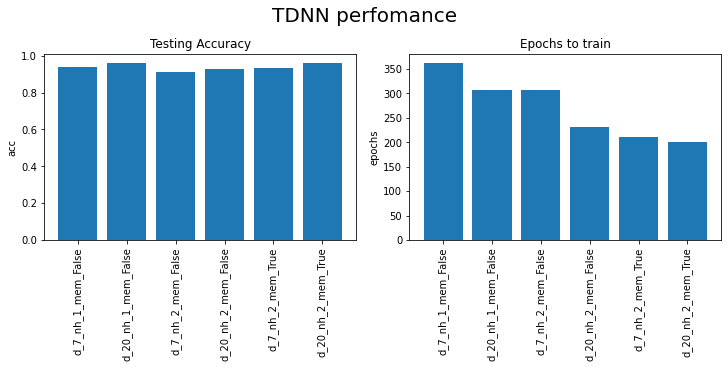

[0.94       0.96200001 0.912      0.926      0.93400002 0.96200001]


In [100]:
## Learning rate
P = np.load('Dict_TDNN.npy', allow_pickle = True)
for key in P.item():
    print(key)
dict_OPT_TBS = P.item()
fig, axs = plt.subplots(1, 2,figsize=(10,5), constrained_layout = True)
epoch_arr = dict_OPT_TBS['epochs']
test_arr = dict_OPT_TBS['test_acc'] 
OPT_Arr = key_list
a = np.arange(len(OPT_Arr))


axs[0].bar(a, test_arr)
axs[0].set_title('Testing Accuracy')
# axs[0].scatter(a, test_arr)
axs[0].set(ylabel = 'acc')
axs[0].xaxis.set_ticks(a) #set the ticks to be a
axs[0].xaxis.set_ticklabels(OPT_Arr,rotation=90)
# axs[0].rc('font', size=12)# ####
# plt.xticks(rotation='vertical')
axs[1].bar(a, epoch_arr)
axs[1].set_title('Epochs to train')
axs[1].set(ylabel = 'epochs')
axs[1].xaxis.set_ticks(a) #set the ticks to be a
axs[1].xaxis.set_ticklabels(OPT_Arr,rotation=90) # change the ticks' names to x

fig.suptitle('TDNN perfomance', fontsize=20)
plt.show()
print(test_arr)

In [101]:
## having memory in the middle does not increase the accuracy at all but it trains faster. 


In [ ]:
best_key = key_list[-1]

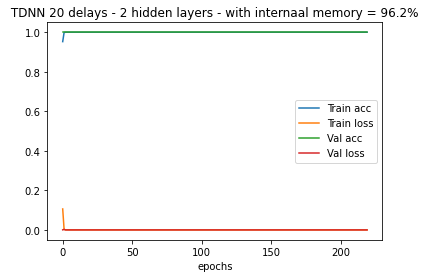

In [102]:
#     d_rnn["train_acc_arr"][key] = History.history['accuracy']
#     d_rnn["train_loss_arr"][key]  = History.history['loss']
#     d_rnn["val_acc_arr"][key] = History.history['val_accuracy']
#     d_rnn["val_loss_arr"][key] = History.history['val_loss']
key = key_list[-1]
train_acc  = d_tdnn_TBS["train_acc_arr"][key]
train_loss = d_tdnn_TBS["train_loss_arr"][key]
val_acc    = d_tdnn_TBS["val_acc_arr"][key]
val_loss   = d_tdnn_TBS["val_loss_arr"][key]
# Train_acc_20delay = results_20delays.history['loss']
# training_vals_loss = Delay7_1layer_dict['loss']
# Val_acc_20delay = results_20delays.history['val_loss']
# valid_vals_loss = Delay7_1layer_dict['val_loss']
# x = list(range(len(training_vals_acc)));
plt.plot(train_acc, label = 'Train acc')
plt.plot( train_loss,label =  'Train loss')
plt.plot( val_acc, label =  'Val acc')
plt.plot( val_loss, label =  'Val loss')
plt.legend()
plt.xlabel('epochs')
plt.title(' TDNN 20 delays - 2 hidden layers - with internaal memory = 96.2% ')
# plt.xlim([.98, 1.05])
plt.show()

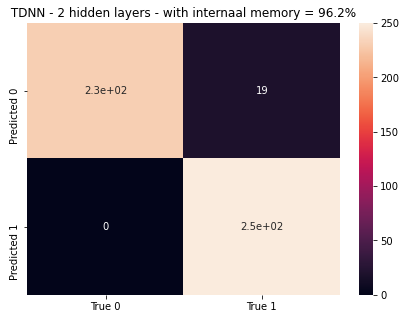

In [109]:
## Confusion matrix 
BestModelPath = 'TDNN_layers_2_delay_20_w_memory.h5'
train_model = load_model(BestModelPath)
predictions = train_model.predict(X_Test)
#
# Get the max probabilites for each rows
probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row  - I have plus 1 because this 
Y_Predicted_classes = np.argmax(predictions, axis = 1)
from sklearn.metrics import confusion_matrix
ConfMat = confusion_matrix(YLabels, Y_Predicted_classes)
import seaborn as sn
confMat = np.transpose(ConfMat)
df_cm = pd.DataFrame(ConfMat, index = ["Predicted 0", "Predicted 1"],
                  columns = ["True 0", "True 1"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True)
plt.title(' TDNN - 2 hidden layers - with internaal memory = 96.2% ')
plt.show()

In [84]:
import keras.backend as K

In [90]:
def custom_loss(y_actual, y_predicted, sigma= .1):
    N = y_actual.shape[0]
    error_vec = y_actual - y_predicted
    
    Error_V, Error_H = np.meshgrid(error_vec, error_vec)
#     print(Error_V)
#     print(Error_H)
    arg_matrix = Error_V - Error_H
#     arg_matrix = np.asarray(arg_matrix, dtype='float64')
#     print(arg_matrix)
#     print(type(N))
#     print(N**2)
    N_dim = int(N**2)
    args = arg_matrix.reshape(N_dim)
#     args_mu = np.mean(args)
#     print(args_mu)
    print(args)
    MEE = np.sum(np.exp(- .5*((args /sigma) **2 )))
    print(MEE)
    return MEE
    

In [91]:
ya = np.ones(4, dtype = 'int')**4
yp = np.ones(4, dtype = 'int')*3
custom_loss(ya,yp)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
16.0


16.0

In [75]:
int(16.0)

16

In [46]:
x =  np.array([1,2,3,4])
x_mesh, y_mesh = np.meshgrid(x,x)

In [15]:
x_mesh

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [16]:
y_mesh

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4]])

In [19]:
np.sum(x_mesh - y_mesh)

0

In [21]:
res = x_mesh- y_mesh

In [24]:
arg = res.reshape(16)
np.exp(arg)

array([ 1.        ,  2.71828183,  7.3890561 , 20.08553692,  0.36787944,
        1.        ,  2.71828183,  7.3890561 ,  0.13533528,  0.36787944,
        1.        ,  2.71828183,  0.04978707,  0.13533528,  0.36787944,
        1.        ])

In [25]:
sum(np.exp(arg))

48.442590564781526

In [88]:
# create network 
network = create_network()
SavePath = "Model_New_Loss_HW4.h5"
delaysize = 7


StopCriteria = 'val_loss'
callbacks = [EarlyStopping(monitor=StopCriteria, patience=20),
         ModelCheckpoint(filepath=SavePath, monitor=StopCriteria, save_best_only=True)]
network = network
network.compile(optimizer='adam',loss=custom_loss,metrics=['accuracy'])


TypeError: unsupported operand type(s) for ** or pow(): 'Dimension' and 'int'

In [58]:
np.cos(np.pi)

-1.0

In [ ]:
history = network.fit(X_Train,Y_Train_oneHot,
                  epochs=epochs,
                  batch_size=batchsize, # Early stopping,
                     verbose = verbose,
                 validation_data=(X_Val,Y_Val_oneHot),
                 callbacks = callbacks)

In [100]:
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
def loss(y_true,y_pred):
    
    loss =  K.mean(K.square(y_pred - y_true))
    return loss

# Return a function
    


IndentationError: expected an indented block (<ipython-input-100-cedef53c14c2>, line 4)

In [129]:
 # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
def loss_fun(y_true,y_pred):
    loss =  K.mean(K.square(y_pred - y_true))
    return loss

# Return a function
    

In [130]:
l = loss_fun(ya, yp)

In [138]:
# Compile the model
network.compile(optimizer='adam',
              loss=loss_fun, # Call the loss function with the selected layer
              metrics=['accuracy'])

In [132]:
l

<tf.Tensor 'Mean_3:0' shape=() dtype=int32>

In [113]:
(2.0)

<tf.Tensor 'Exp_1:0' shape=() dtype=float32>

In [143]:
import tensorflow as tf

In [169]:
def custom_loss(sigma =.1):
    def loss_fun(y_actual, y_predicted):
        y_actual = tf.convert_to_tensor(y_actual, dtype='float32' )
        y_predicted = tf.convert_to_tensor(y_predicted ,dtype='float32' )
        N = y_actual.shape[0]
        error_vec = y_actual - y_predicted    
        Error_V, Error_H = tf.meshgrid(error_vec, error_vec)
        arg_matrix = Error_V - Error_H
        MEE = K.sum(K.exp(- .5*((arg_matrix /sigma) **2 )))
    #     print(MEE)
        return MEE
    return loss_fun
    

In [170]:
l = custom_loss(.2)

In [171]:
tf.convert_to_tensor(ya)

<tf.Tensor 'Const_76:0' shape=(4,) dtype=int32>

In [172]:
# Compile the model
network.compile(optimizer='adam',
              loss=custom_loss(.1), # Call the loss function with the selected layer
              metrics=['accuracy'])

In [173]:
train_TDNN(network , 'testing_hw4.h5', 7)

Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 1s 875us/step - loss: 5.9605e-10 - accuracy: 1.0000 - val_loss: 2.3842e-09 - val_accuracy: 1.0000
Epoch 2/1000
800/800 [==============================] - 0s 400us/step - loss: 5.9605e-10 - accuracy: 1.0000 - val_loss: 2.3842e-09 - val_accuracy: 1.0000
Epoch 3/1000
800/800 [==============================] - 0s 439us/step - loss: 4.4703e-10 - accuracy: 1.0000 - val_loss: 2.3842e-09 - val_accuracy: 1.0000
Epoch 4/1000
800/800 [==============================] - 1s 890us/step - loss: 5.9605e-10 - accuracy: 1.0000 - val_loss: 2.3842e-09 - val_accuracy: 1.0000
Epoch 5/1000
800/800 [==============================] - 1s 903us/step - loss: 4.4703e-10 - accuracy: 1.0000 - val_loss: 1.7881e-09 - val_accuracy: 1.0000
Epoch 6/1000
800/800 [==============================] - 1s 906us/step - loss: 5.9605e-10 - accuracy: 1.0000 - val_loss: 1.7881e-09 - val_accuracy: 1.0000
Epoch 7/1000
800/800 [========

KeyboardInterrupt: 

In [159]:
# test the network on the testing data
trained_network = load_model('testing_hw4.h5')
test_loss, test_acc = trained_network.evaluate(X_Test,Y_Test_OneHot)
print(test_acc)

500/500 [==============================] - 0s 302us/step
0.9440000057220459
